# next
* fix all tests
* make the diagonals not connect
* simulate brain below with and without hebbian learning AND decrease random perturbation over time
* create a ground neuron that is always on (this is needed to create a NAND)
* directly create a NAND (maybe make a nand classmethod constructor)
* see if you can converge to a NAND given an initial topology that works
* do all synapses need to have the possibility of being both inhibitory and excitatory? what then?

In [104]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [50,50]

import brain; import importlib; importlib.reload(brain);

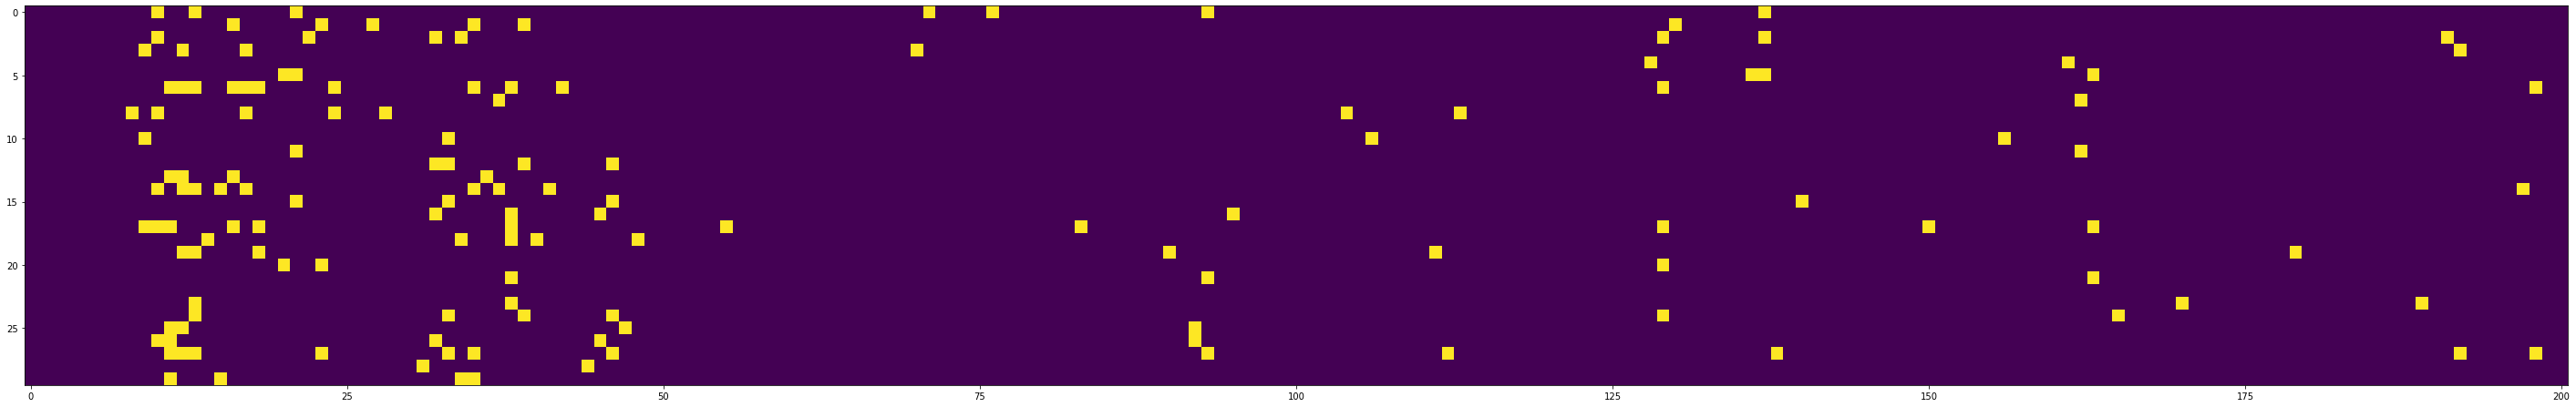

In [175]:
b = brain.Brain(
    num_neurons=30, 
    synaptic_density=0.3,
    random_activation_scale=0.1,
    learning_rate=1,
)
b.simulate_brain(
    200,
    with_hebbian_learning=True,
)

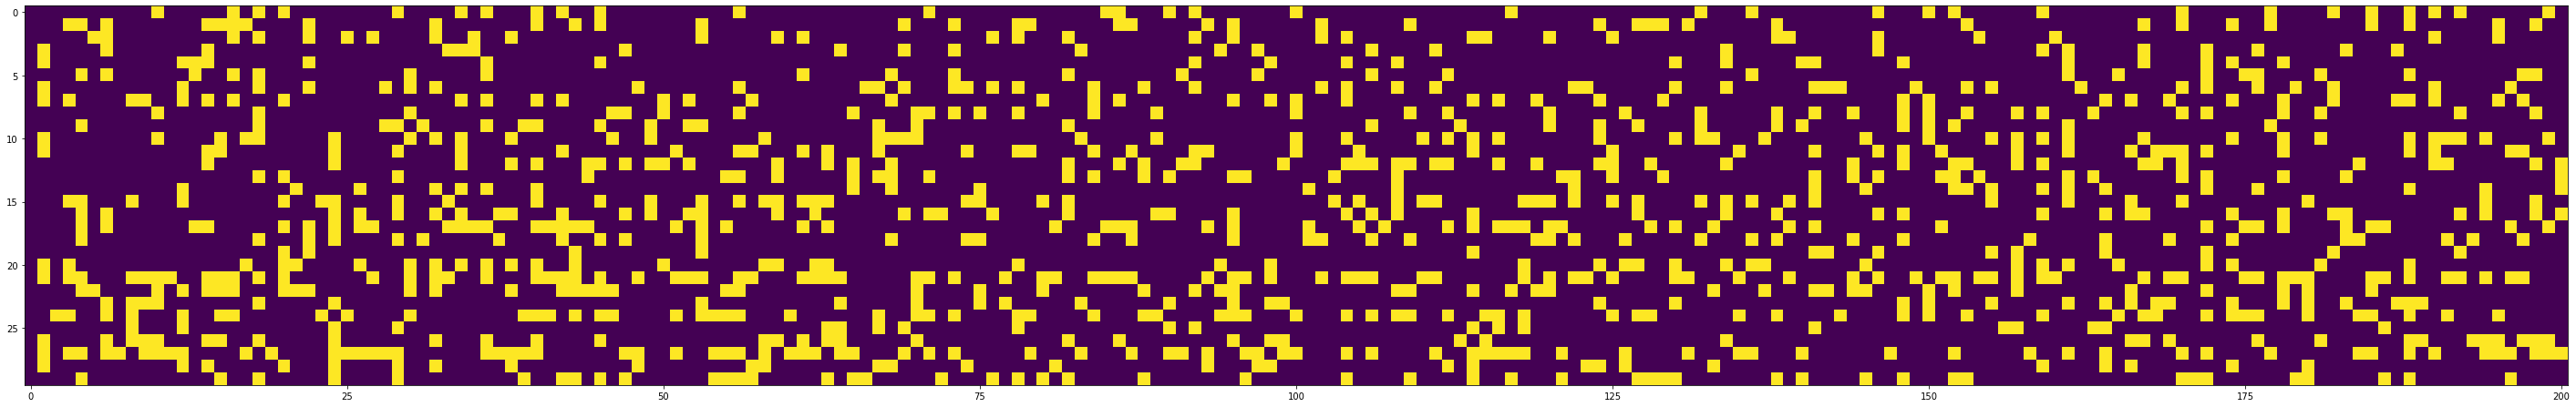

In [176]:
b.random_activation_scale=0.5
b.simulate_brain(
    200,
    with_hebbian_learning=False,
)

In [98]:
b.synapses_a.data,b.synapses_b.data,

(array([  3.,   5.,  87.,  40.,  95.,   9.,   9., 168.,  84.,  39.,   8.,
          5.,   2.,   1.,   2.,   9.,   1.,  40.,  23.,  17.]),
 array([ 17., 166.,   1.,   1.,   1.,   2.,  79.,   3.,   4.,   2.,  80.,
         48.,  68.,  66.,  51., 183.,  10.,   1.,  44.,  79.]))

In [100]:
x = np.ones([4,4])

In [102]:
x[:] = 3

In [103]:
x

array([[3., 3., 3., 3.],
       [3., 3., 3., 3.],
       [3., 3., 3., 3.],
       [3., 3., 3., 3.]])